# [ECE-GY: 7123] Deep Learning
# Spring 2024

In [1]:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torchvision.utils import make_grid
import warnings

warnings.filterwarnings('ignore')

### Transforms for data

In [46]:
# Defining transforms for training, validation and testing data:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [47]:
# Downloading training and testing data:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
# Initializing batch size:
batch=64

In [ ]:
# Creating training and testing dataloaders:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False, num_workers=2)

### Visualizing the dataset

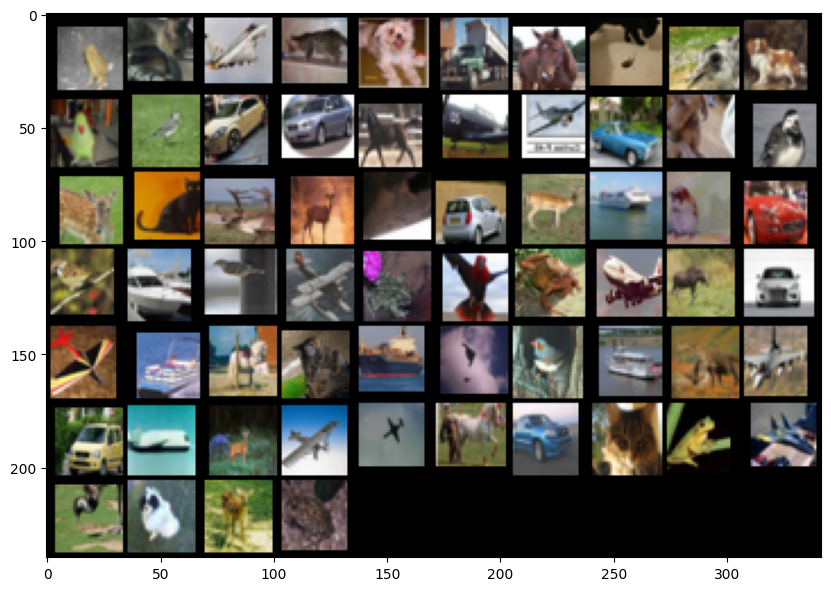

In [50]:
#visualizing training data

data_stats = [(0.5,0.5,0.5),(0.5,0.5,0.5)]

def denormalize(images,means,stdDev):
    means = torch.tensor(means).reshape(1,3,1,1)
    stdDev = torch.tensor(means).reshape(1,3,1,1)
    return(images*stdDev+means)

def showPreview(dl):

    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
        break

showPreview(train_loader)

In [10]:
# Getting class names from the dataset:
classes = train_set.class_to_idx
classes

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [60]:
# Define residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [59]:
# Modified ResNet model
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32  # Reduced number of initial channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)  # Reduced initial channels
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)  # Reduced channels
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)  # Reduced channels
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)  # Reduced channels
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [53]:
# Creating lists for train and test loss and accuracies:
train_losses = []
train_acc = []
val_losses_l1 = []
val_acc_l1 = []

In [54]:
# Function train:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

In [70]:
# Function test:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_losses_l1 = []
    test_acc_l1 = []
    correct = 0
    criterion= nn.CrossEntropyLoss().to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [56]:
# Geting cpu or gpu device for training:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {torch.cuda.get_device_name()}")

Using NVIDIA GeForce RTX 3050 Laptop GPU


In [62]:
# Instantiate the modified ResNet model
model = ModifiedResNet(BasicBlock, [2, 2, 2, 2])
# model.load_state_dict(torch.load('modified_resnet_cifar10_model_40_epochs.pth'))
model.eval()
# Move the model to the same device as the input data
model.to(device)

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1,

In [63]:
# Displaying number of trainable parameters:
print("Total number of parameters in the model: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of parameters in the model:  2797610


In [64]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [72]:
# Initializing batch size Learning Rate annd moment:
epochs = 40
LR = 0.01
# moment = 0.9

# Training the model over training and testing datasets:

optimizer = optim.Adam(model.parameters(), 
                       lr=0.001, 
                       weight_decay=1e-4)

scheduler = OneCycleLR(optimizer,
                       max_lr=0.01,
                       total_steps=epochs)

for epoch in range(epochs):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)
    scheduler.step()

Epoch: 0 Learning_Rate [0.0003999999999999993]


Loss=1.2670228481292725 Batch_id=781 Accuracy=58.58: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.18it/s]



Test set: Average loss: 0.0169, Accuracy: 6124/10000 (61.2400%)

Epoch: 1 Learning_Rate [0.0005944337266504118]


Loss=1.2210078239440918 Batch_id=781 Accuracy=62.95: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.12it/s]



Test set: Average loss: 0.0158, Accuracy: 6391/10000 (63.9100%)

Epoch: 2 Learning_Rate [0.0011619830424103288]


Loss=0.9151483774185181 Batch_id=781 Accuracy=65.04: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.11it/s]



Test set: Average loss: 0.0150, Accuracy: 6582/10000 (65.8200%)

Epoch: 3 Learning_Rate [0.00205666847706263]


Loss=0.8389028310775757 Batch_id=781 Accuracy=67.12: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.16it/s]



Test set: Average loss: 0.0143, Accuracy: 6808/10000 (68.0800%)

Epoch: 4 Learning_Rate [0.0032060079375909444]


Loss=0.9648670554161072 Batch_id=781 Accuracy=68.51: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.12it/s]



Test set: Average loss: 0.0136, Accuracy: 6945/10000 (69.4500%)

Epoch: 5 Learning_Rate [0.00451688877628823]


Loss=1.1575337648391724 Batch_id=781 Accuracy=69.68: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.07it/s]



Test set: Average loss: 0.0137, Accuracy: 6898/10000 (68.9800%)

Epoch: 6 Learning_Rate [0.005883111223711768]


Loss=0.7676910161972046 Batch_id=781 Accuracy=70.23: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.10it/s]



Test set: Average loss: 0.0151, Accuracy: 6603/10000 (66.0300%)

Epoch: 7 Learning_Rate [0.007193992062409054]


Loss=0.679681658744812 Batch_id=781 Accuracy=70.61: 100%|████████████████████████████| 782/782 [01:17<00:00, 10.12it/s]



Test set: Average loss: 0.0149, Accuracy: 6641/10000 (66.4100%)

Epoch: 8 Learning_Rate [0.008343331522937368]


Loss=0.7291592955589294 Batch_id=781 Accuracy=71.07: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.12it/s]



Test set: Average loss: 0.0140, Accuracy: 6875/10000 (68.7500%)

Epoch: 9 Learning_Rate [0.00923801695758967]


Loss=0.45789384841918945 Batch_id=781 Accuracy=71.22: 100%|██████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0153, Accuracy: 6572/10000 (65.7200%)

Epoch: 10 Learning_Rate [0.009805566273349588]


Loss=1.6022862195968628 Batch_id=781 Accuracy=71.76: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.18it/s]



Test set: Average loss: 0.0132, Accuracy: 7030/10000 (70.3000%)

Epoch: 11 Learning_Rate [0.01]


Loss=0.9729700088500977 Batch_id=781 Accuracy=72.47: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.16it/s]



Test set: Average loss: 0.0150, Accuracy: 6597/10000 (65.9700%)

Epoch: 12 Learning_Rate [0.009968561175222016]


Loss=1.1579045057296753 Batch_id=781 Accuracy=72.76: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0135, Accuracy: 7060/10000 (70.6000%)

Epoch: 13 Learning_Rate [0.009874640062350875]


Loss=0.820927083492279 Batch_id=781 Accuracy=73.17: 100%|████████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0150, Accuracy: 6664/10000 (66.6400%)

Epoch: 14 Learning_Rate [0.009719417773875232]


Loss=0.7768478393554688 Batch_id=781 Accuracy=73.63: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0152, Accuracy: 6713/10000 (67.1300%)

Epoch: 15 Learning_Rate [0.009504846320134737]


Loss=0.7432413697242737 Batch_id=781 Accuracy=73.76: 100%|███████████████████████████| 782/782 [01:17<00:00, 10.15it/s]



Test set: Average loss: 0.0126, Accuracy: 7238/10000 (72.3800%)

Epoch: 16 Learning_Rate [0.009233624061657435]


Loss=1.5208125114440918 Batch_id=781 Accuracy=74.10: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0144, Accuracy: 6896/10000 (68.9600%)

Epoch: 17 Learning_Rate [0.0089091617757105]


Loss=1.6186696290969849 Batch_id=781 Accuracy=74.85: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.17it/s]



Test set: Average loss: 0.0120, Accuracy: 7351/10000 (73.5100%)

Epoch: 18 Learning_Rate [0.008535539763797114]


Loss=0.3785282373428345 Batch_id=781 Accuracy=75.05: 100%|███████████████████████████| 782/782 [01:16<00:00, 10.16it/s]



Test set: Average loss: 0.0119, Accuracy: 7407/10000 (74.0700%)

Epoch: 19 Learning_Rate [0.008117456539497631]


Loss=1.0648696422576904 Batch_id=213 Accuracy=75.22:  27%|███████▍                   | 214/782 [00:26<01:10,  8.01it/s]


KeyboardInterrupt: 

In [73]:
#converting from cuda tensors to .cpu()

arr_train=np.array(torch.Tensor(train_losses).cpu())

arr_val=np.array(torch.Tensor(test_losses_l1).cpu())

arr_train_acc=np.array(torch.Tensor(train_acc).cpu())

arr_val_acc=np.array(torch.Tensor(test_acc_l1).cpu())

NameError: name 'test_losses_l1' is not defined

In [43]:
# Getting the train loss for the last batch for every epoch:
arr_train1 =[]
for i in range(len(arr_train)):
  if (i%1563) == 0:
    arr_train1.append(arr_train[i])

In [74]:
# Plotting the accuracy:
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","val"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'arr_train_acc' is not defined

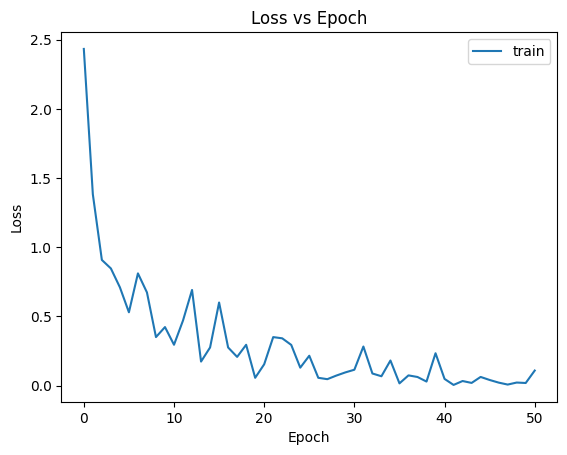

In [45]:
# Printing train  and test loss:
plt.plot(arr_train1 )
plt.legend(["train"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

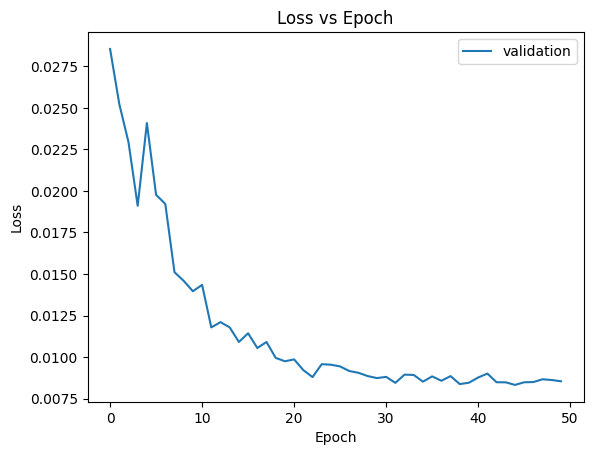

In [46]:
plt.plot(arr_test)
plt.legend(["validation"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [75]:
# Save random initial weights:
torch.save(model.state_dict(), 'Resnet_state_dict.pt')

model.cpu()
model_scripted = torch.jit.script(model)
model_scripted.save('ResNet_sgd_cifar10.pt')
print("Saved Model")

Saved Model


# Testing the Model

In [76]:
from PIL import Image
import pandas as pd
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torchinfo
import torchvision.transforms as T

In [77]:
model = torch.jit.load("Resnet56Adam.pt")

In [78]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [79]:
no_label_data = unpickle("cifar_test_nolabels.pkl")

In [80]:
imgs = no_label_data[b'data']
# Reshape the data to the correct format (num_images, 3, 32, 32)
reshaped_data = imgs.reshape((-1, 3, 32, 32)).astype(np.float32)

# Convert the first image to a PyTorch tensor and add a batch dimension
# Assuming pixel values are expected to be in the range [0, 1] for the model
unlabeled_test = torch.tensor(reshaped_data/ 255).unsqueeze(0)



In [81]:
from torch.utils.data import Dataset

class CIFARCustomDataset(Dataset):
    """Custom Dataset for loading CIFAR images on-the-fly."""

    def __init__(self, data):
        """
        Args:
            data (numpy.ndarray): The array containing CIFAR image data.
        """
        self.data = data

    def __len__(self):
        """Denotes the total number of samples."""
        return len(self.data)

    def __getitem__(self, index):
        """Generates one sample of data."""
        # Load data and get label
        x = self.data[index]
        # Reshape and normalize the image data
        x = x.reshape(3, 32, 32).astype(np.float32) / 255
        return torch.tensor(x)

# Create an instance of our custom dataset
custom_dataset = CIFARCustomDataset(data=reshaped_data)

# Create the DataLoader using the custom dataset
dataloader_custom = DataLoader(custom_dataset, batch_size=64, shuffle=False)

# Show an example of getting a batch from the custom dataloader
for images in dataloader_custom:
    print(f"Batch shape: {images.shape}")
    break  # We only want to show the shape of the first batch as an example

Batch shape: torch.Size([64, 3, 32, 32])


In [82]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    
def get_predictions(model, iterator, device):
    model.eval()
    test_acc = 0
    labels = []
    probs = []
    with torch.no_grad():      
        for x in iterator:
            # x = x.to(device)
            y_pred= model(x)
            probs.append(y_pred.to(torch.device('cpu')))
        probs = torch.cat(probs, dim = 0)
        print("Completed Predictions on Data Loader.")
    return probs

In [83]:
 probs = get_predictions(model, dataloader_custom, device)  
# Pick the class having maximum predicted probabily
pred_labels = torch.argmax(probs, 1)
pred_labels

Completed Predictions on Data Loader.


tensor([8, 8, 8,  ..., 3, 5, 8])

In [84]:
pred_classes = {value: key for key, value in classes.items()}
matched_labels = [pred_classes[index] for index in pred_labels.tolist()]
matched_labels

['ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'cat',
 'ship',
 'ship',
 'ship',
 'deer',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'deer',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'deer',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'truck',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 'ship',
 

In [36]:
import csv

# File path for the new CSV
csv_file_path = 'predictions.csv'

# Writing to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Writing the header (optional)
    writer.writerow(['ID', 'Labels'])
    
    # Writing the data
    for name, age in zip(no_label_data[b'ids'], pred_labels.tolist()):
        writer.writerow([name, age])

print(f"CSV file '{csv_file_path}' has been created.")

CSV file 'predictions.csv' has been created.
